In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MultiLabelBinarizer
import tqdm
import csv
import random
from sklearn.decomposition import PCA
import pyreadr
import gensim 

%config IPCompleter.greedy=True

In [4]:
DIRECTORY = '/Users/diyahirc/Files/BCM Research/msigdb' # Change to your path
# DIRECTORY = '/Users/diyahirc/Files/BCM/genesets' # Change to your path

In [5]:
def parseGeneSetFile(path:str):
    # Parse Geneset gmt files into list of sets
    
    geneSetList = []
    MINSETSIZE = 2
    
    tempFile = open(path,'r')
    print(path)
    
    tempLines = tempFile.readlines()
    count = 0
    for line in tempLines:
        line = line.upper()
        line = line.strip('\n') 
        tempGeneSet = line.split('\t')[2:] # first two entries are 'geneSet name' and 'discription'   
        if len(tempGeneSet) >= MINSETSIZE:           # not interested in single gene'd gene sets
            geneSetList.append(set(tempGeneSet))
    return geneSetList

In [6]:
# Parse all of the genesets 

DB = {'CBOW':{},'2VEC':{}}

geneSetList = []

for fileName in os.listdir(DIRECTORY):
    tempList = []
    tempPath = os.path.join(DIRECTORY, fileName)
    geneSetList = geneSetList + parseGeneSetFile(tempPath)

/Users/diyahirc/Files/BCM Research/msigdb/c6.all.v7.2.symbols.gmt
/Users/diyahirc/Files/BCM Research/msigdb/c3.all.v7.2.symbols.gmt
/Users/diyahirc/Files/BCM Research/msigdb/c8.all.v7.2.symbols.gmt
/Users/diyahirc/Files/BCM Research/msigdb/c7.all.v7.2.symbols.gmt
/Users/diyahirc/Files/BCM Research/msigdb/h.all.v7.2.symbols.gmt
/Users/diyahirc/Files/BCM Research/msigdb/c4.all.v7.2.symbols.gmt
/Users/diyahirc/Files/BCM Research/msigdb/msigdb.v6.1.symbols.gmt


In [7]:
from gensim.models import KeyedVectors

MODELPATH = "/Users/diyahirc/Files/BCM Research/trained_embeddings/alldata/gene2vec_dim_v2_200_iter_60.model"
cbowModel = KeyedVectors.load(MODELPATH)
DB['CBOW']['model'] = cbowModel

gene2vecMODELPATH = "/Users/diyahirc/Files/BCM Research/gen2vec/Gene2vec/pre_trained_emb/gene2vec_dim_200_iter_9_w2v.txt"
gene2vecModel = gensim.models.KeyedVectors.load_word2vec_format(gene2vecMODELPATH)
DB['2VEC']['model'] = gene2vecModel


In [8]:
def getSetsInVocab(geneModel):
    setsInVocab = []
    MINLENGTH = 2
    for index in range(len(geneSetList)):
            geneSet = geneSetList[index]
    #         if len(geneSet) == 14:
            allContainedFlag = 1 # make sure all the genes in the test set are in the vocab
            for gene in geneSet:
                if gene not in geneModel.wv.vocab:
                    allContainedFlag = 0
            if allContainedFlag:
                if len(geneSet) > MINLENGTH:
                    setsInVocab.append(geneSet)
                    testSet = geneSet
    #             print(geneSet)
    #             asdas
    print('Number of Genes in Emb  = {vocablen}'.format(vocablen=len(geneModel.wv.vocab)))
    print('Number of sets in vocab = {setInVcab}'.format(setInVcab = len(setsInVocab)))
    
    return setsInVocab

print('CBOW ---- ')
DB['CBOW']['sets'] = getSetsInVocab(DB['CBOW']['model'])
print('\n')

print('2VEC ---- ')
DB['2VEC']['sets'] = getSetsInVocab(DB['2VEC']['model'])


CBOW ---- 
Number of Genes in Emb  = 12254
Number of sets in vocab = 2464


2VEC ---- 


<ipython-input-8-e33e158d618b>:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if gene not in geneModel.wv.vocab:


Number of Genes in Emb  = 24447
Number of sets in vocab = 4969


<ipython-input-8-e33e158d618b>:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print('Number of Genes in Emb  = {vocablen}'.format(vocablen=len(geneModel.wv.vocab)))


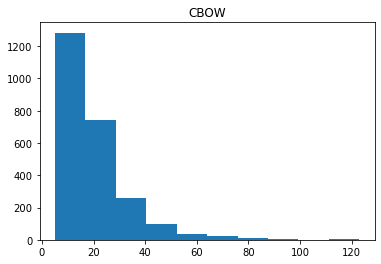

DescribeResult(nobs=2464, minmax=(5, 123), mean=20.37702922077922, variance=169.92072263657982, skewness=2.467489956470792, kurtosis=9.08080873709578)


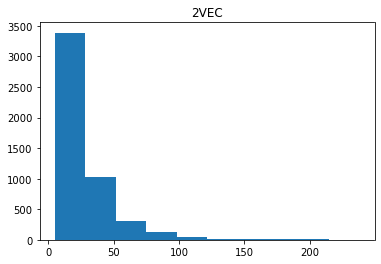

DescribeResult(nobs=4969, minmax=(5, 238), mean=27.908633527872812, variance=613.0588807612025, skewness=3.1680157987704005, kurtosis=14.592977493336004)


In [9]:
setLens = [len(geneSet) for geneSet in DB['CBOW']['sets']]
plt.hist(setLens)
plt.title('CBOW')
plt.show()
print(stats.describe(setLens))

setLens = [len(geneSet) for geneSet in DB['2VEC']['sets']]
plt.hist(setLens)
plt.title('2VEC')
plt.show()
print(stats.describe(setLens))


In [12]:
def geneEmbDistance(gene1:str,gene2:str,geneModel) -> float:
    tempVec1 = geneModel.wv[gene1]
    tempVec2 = geneModel.wv[gene2]
    
    dist = np.linalg.norm(tempVec1-tempVec2)
    
    return dist

def getAvgVecSet(geneSet:set,geneModel):
    avgVec = np.zeros(200)
    
    for gene in geneSet:
        avgVec += geneModel.wv[gene]
    
    return avgVec/len(geneSet)


def geneSetDistance(geneSet1:set,geneSet2:set,case:int,geneModel):
    size1 = len(geneSet1)
    size2 = len(geneSet2)
    
    distance = 0
    
    # Pairwise Aproaches 
    for myGene in geneSet1:        
        if myGene not in geneSet2:
            tempVec = geneModel.wv[myGene]
            
            if case == 1: # 2-Norm Distance from centroid of comparison set
                centroid = getAvgVecSet(geneSet2,geneModel)
                tempDist = np.linalg.norm(tempVec-centroid)
                distance += tempDist
                
            if case == 2: # Minimum 2-Norm distance from 
                
                minDistance = float('inf')
                
                for dbGene in geneSet2:
                    dbGeneVec = geneModel.wv[dbGene]
                    tempDist = np.linalg.norm(tempVec-dbGeneVec)

                    if tempDist < minDistance:
                        minDistance = tempDist   
                                        
                distance += minDistance
        
            if case ==3: # Cosine Similarity to Centroid
                centroid = getAvgVecSet(geneSet2,geneModel)                
                dot = np.dot(centroid, tempVec)
                norma = np.linalg.norm(centroid)
                normb = np.linalg.norm(tempVec)
                
                distance  += dot / (norma * normb)
        else:
            if case == 3:
                distance += 1
                # add 1 for intersecting genes since this is a similarity based approach
    
    # Centroid approaches 
    if case == 4:
        # take set difference centroid and find cosine similarity with other set's centroid
        geneSetDifference = geneSet1.difference(geneSet2)
        if len(geneSetDifference) > 0:
            centroidDiff = getAvgVecSet(geneSetDifference,geneModel)
            centroidComp = getAvgVecSet(geneSet2,geneModel)

            dot = np.dot(centroidDiff, centroidComp)
            norma = np.linalg.norm(centroidDiff)
            normb = np.linalg.norm(centroidComp)

            distance  += dot / (norma * normb)
            
        distance += len(geneSet1.intersection(geneSet2))
    return distance/size1 # Normalizing by size 

def getGeneSetDistance(geneSet1:set,geneSet2:set,case:int,geneModel):
    forwardDirection = geneSetDistance(geneSet1,geneSet2,case,geneModel)
    backwardDirection = geneSetDistance(geneSet2,geneSet1,case,geneModel)
    return 0.5*(forwardDirection + backwardDirection)


In [13]:
commonSets = []

for set1 in tqdm.tqdm(DB['CBOW']['sets']):
    for set2 in DB['2VEC']['sets']:
        if set1 == set2:
            commonSets.append(set1)

print(len(commonSets))

100%|██████████| 2464/2464 [00:01<00:00, 2438.47it/s]

2363


In [14]:
testSet = []
while len(testSet) < 18:
    testSet =  random.choice(commonSets)
print(testSet)
print(len(testSet))


{'BCL2L1', 'PPFIA1', 'TGFB1', 'CLTC', 'DAB2', 'PKDCC', 'NUMB', 'ANXA13', 'TMBIM1', 'GOPC', 'LYPLA1', 'TMEM59', 'LRRC15', 'GBP1', 'PID1', 'RHOQ', 'AP2M1', 'PPP2R5A', 'LZTFL1', 'CSK'}
20


In [15]:
# Exploring impact of removing random genes, or pairs of genes on similarity / distance (to see range)
from itertools import combinations  

case = 4

comb = combinations(testSet, len(testSet)-1)  
removeOneDists = []
removeOneDistsMin = []

# Print the obtained combinations  
for perm in list(comb):  
    perm = set(perm)
    tempDist1 = getGeneSetDistance(perm,testSet,case,DB['2VEC']['model'])
    tempDist2 = getGeneSetDistance(perm,testSet,case,DB['2VEC']['model'])
    removeOneDists.append(tempDist1)
    removeOneDistsMin.append(tempDist2)
    
    
comb = combinations(testSet, len(testSet)-3)  
addRandGeneDists = []
for perm in list(comb):

    randGene = random.choice(list(DB['2VEC']['model'].wv.vocab.keys()))
    perm = list(perm)
    perm.append(randGene)
    perm = set(perm)

    addRandGeneDists.append(getGeneSetDistance(perm,testSet,case,DB['2VEC']['model']))


comb = combinations(testSet, len(testSet)-2)  
remove2Dists = []
# Print the obtained combinations  
for perm in list(comb):  
    perm = set(perm)

    remove2Dists.append(getGeneSetDistance(perm,testSet,case,DB['2VEC']['model']))
    
comb = combinations(testSet, len(testSet)-3)  
remove3Dists = []
# Print the obtained combinations  
for perm in list(comb):  
    perm = set(perm)

    remove3Dists.append(getGeneSetDistance(perm,testSet,case,DB['2VEC']['model']))

randGenesDists = []
for i in range(10):
#     print(i)
    tempSet = set()
    for ind in range(len(testSet)):
        randGene = random.choice(list(DB['2VEC']['model'].wv.vocab.keys()))
#         print(randGene)
        tempSet.add(randGene)
#     print(tempSet)
    randGenesDists.append(getGeneSetDistance(tempSet,testSet,case,DB['2VEC']['model']))
print('Done!')

<ipython-input-12-898fa8e01263>:27: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  tempVec = geneModel.wv[myGene]
<ipython-input-12-898fa8e01263>:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  avgVec += geneModel.wv[gene]
<ipython-input-15-2406b1527707>:23: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  randGene = random.choice(list(DB['2VEC']['model'].wv.vocab.keys()))


Done!


<ipython-input-15-2406b1527707>:52: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  randGene = random.choice(list(DB['2VEC']['model'].wv.vocab.keys()))


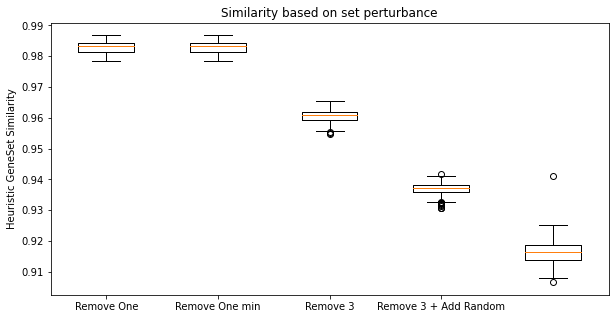

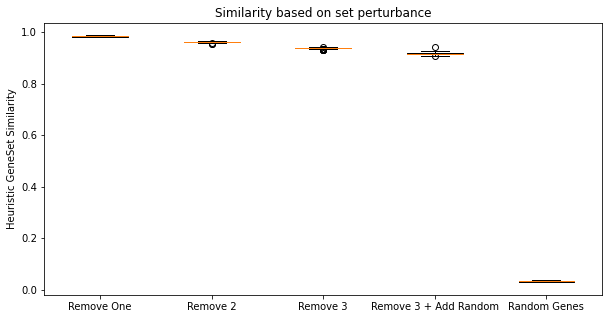

In [16]:
plt.figure(figsize=(10,5))

plt.boxplot([removeOneDists,removeOneDistsMin,remove2Dists,remove3Dists,addRandGeneDists])
plt.ylabel('Heuristic GeneSet Similarity')
plt.title('Similarity based on set perturbance')
plt.xticks([1,2,3,4],['Remove One','Remove One min','Remove 3','Remove 3 + Add Random'])
plt.show()

plt.figure(figsize=(10,5))

plt.boxplot([removeOneDists,remove2Dists,remove3Dists,addRandGeneDists,randGenesDists])
plt.ylabel('Heuristic GeneSet Similarity')
plt.title('Similarity based on set perturbance')
plt.xticks([1,2,3,4,5],['Remove One','Remove 2','Remove 3','Remove 3 + Add Random','Random Genes'])
plt.show()

In [17]:
# distancesFromTest = [(getGeneSetDistance(tempSet,testSet,1),getGeneSetDistance(tempSet,testSet,2))  for tempSet in tqdm.tqdm(setsInVocab)]

# testSet =  random.choice(commonSets)
# print(testSet)
# print(len(testSet))

distancesFromTest = [[getGeneSetDistance(tempSet,testSet,3,DB['CBOW']['model']),getGeneSetDistance(tempSet,testSet,4,DB['CBOW']['model'])]  
                     for tempSet in tqdm.tqdm(commonSets)]

100%|██████████| 2363/2363 [00:08<00:00, 290.41it/s]


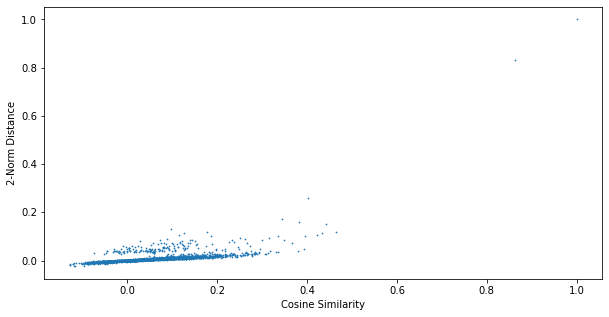

In [18]:
plt.figure(figsize=(10,5))

plt.scatter([x[0] for x in distancesFromTest],[x[1] for x in distancesFromTest] ,s=0.5)
plt.ylabel('2-Norm Distance')
plt.xlabel('Cosine Similarity')
plt.show()


In [19]:
from scipy.stats import hypergeom

def getPValue(sampleSet:set,functionalSet:set):
    # calculates hypergeometric test on pair of gene sets
    
    [M, n, N] = [24447, len(functionalSet), len(sampleSet)]
    rv = hypergeom(M, n, N)
    x = np.arange(0, n+1)
    pmfgenes = rv.pmf(x)
    
    interSet = sampleSet.intersection(functionalSet)
    
    cdf = []
    for ind in range(len(pmfgenes)):
        cdf.append(np.sum(pmfgenes[ind+1:]))
        
    return cdf[len(interSet)]


def getInterSectPercentage(set1:set,set2:set):
    percentIntersection = len(set1.intersection(set2))/len(set1.union(set2))
    return percentIntersection
    
    

In [20]:
setsWithDists = [ [commonSets[ind],distancesFromTest[ind][0], getInterSectPercentage(testSet,commonSets[ind]),getPValue(testSet,commonSets[ind]),distancesFromTest[ind][1],distancesFromTest[ind][0]] 
                 for ind in tqdm.tqdm(range(len(commonSets)))]

setsWithDists.sort(key = lambda x: x[1]) 

100%|██████████| 2363/2363 [00:02<00:00, 949.50it/s] 


In [21]:
dists = [ x[1] for x in setsWithDists]
minDists = [ x[4] for x in setsWithDists]
cbowDists = [ x[5] for x in setsWithDists]

pvals =  [ np.log(x[3]) for x in setsWithDists]
setInters =  [ x[2] for x in setsWithDists]

<ipython-input-21-42e15633b4b4>:5: RuntimeWarning: divide by zero encountered in log
  pvals =  [ np.log(x[3]) for x in setsWithDists]


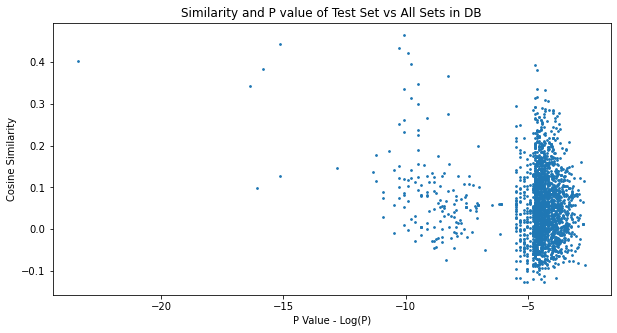

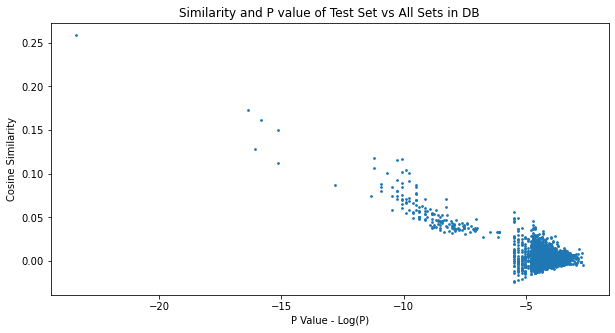

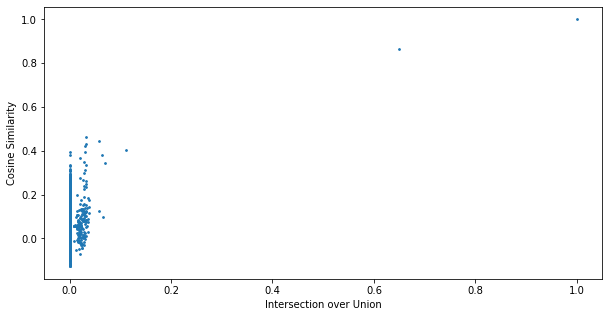

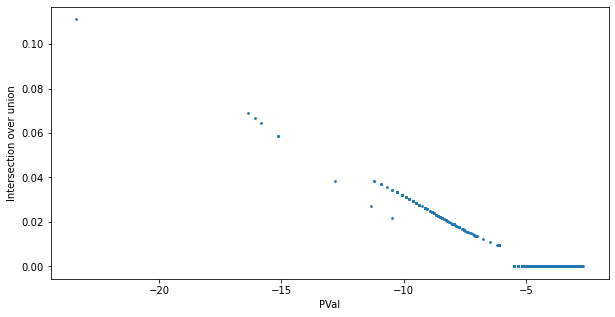

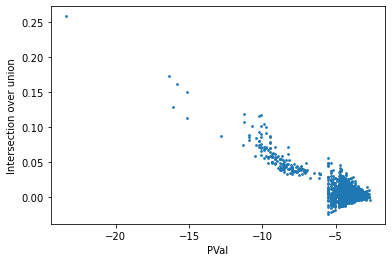

In [22]:
# print(distVsIntersec)
plt.figure(figsize=(10,5))

plt.scatter(pvals,dists,s=3)

plt.title('Similarity and P value of Test Set vs All Sets in DB')
plt.ylabel('Cosine Similarity')
plt.xlabel('P Value - Log(P)')
plt.show()

plt.figure(figsize=(10,5))

plt.scatter(pvals,minDists,s=3)

plt.title('Similarity and P value of Test Set vs All Sets in DB')
plt.ylabel('Cosine Similarity')
plt.xlabel('P Value - Log(P)')
plt.show()

plt.figure(figsize=(10,5))

plt.scatter(setInters,dists,s=3)
plt.ylabel('Cosine Similarity')
plt.xlabel('Intersection over Union')
plt.show()

plt.figure(figsize=(10,5))

plt.scatter(pvals,setInters,s=3)
plt.ylabel('Intersection over union')
plt.xlabel('PVal')
plt.show()

plt.scatter(pvals,minDists,s=3)
plt.ylabel('Intersection over union')
plt.xlabel('PVal')
plt.show()

# Distinguishing Signal from noise

We will be creating a mock db to see if we can distinguish noise from signal

In [23]:
# converting from genesymbol to entrex

from collections import defaultdict

saveToCsv = False

def def_value(): 
    return ""

if saveToCsv:
    
    gsData2save = []
    
    mapping = pd.read_csv('hsapiens_genesymbol_entrezgene.table.txt',sep='\t',header=None)
    lol = mapping.values.tolist()
    mappingDict = defaultdict(def_value)

    for item in lol:
        mappingDict[item[1]] = item[0]

In [24]:
def IOU(A:set,B:set):
    return (len(A.intersection(B))/len(A.union(B)))

def set2Entrez(geneSet):
    
    entrezSet = [mappingDict[geneSymb] for geneSymb in geneSet]
        
    return entrezSet

def saveExpData(listOfGS):
    # creates delim string of the genesets
    
    entrezLists = [';'.join(map(str,set2Entrez(GS))) for GS in listOfGS]
        
    return entrezLists 
    
def runExperiement1(case:int,percRemove:int,saveToCsv:bool,geneModel,setsInVocab):  
    A =  random.choice(setsInVocab)   
    
    numRemove = int(np.floor(float(percRemove)*len(A)))
    A1 = set(random.sample(A, len(A) - numRemove))   
    randGenes = set(random.sample(geneModel.wv.vocab.keys(),numRemove))    
    B = A1.union(randGenes)

    ADist = getGeneSetDistance(A,A1,case,geneModel)
    
    BDist = getGeneSetDistance(B,A1,case,geneModel)
    
    if saveToCsv:
        tempData = saveExpData([A,A1,B])
        gsData2save.append(tempData)
    
    IOUtemp = IOU(A1,A)

    return ([ADist,BDist,IOUtemp])

def getExperiment1Results(case,model,saveToCsv,operator:bool):
    # operator true means greater than (similar), false means less than (distance)
    percentCorrect = []
    percentsToRemove = np.linspace(0.05,0.9,20)

    for percGenesToRemove in tqdm.tqdm(percentsToRemove):
        expData = [ runExperiement1(case,percGenesToRemove,saveToCsv,model,commonSets) for i in range(250)]
        # print(expData)

        Adist = [x[0] for x in expData]
        Bdist = [x[1] for x in expData]
        
        if operator:
            As = [Adist[ind] > Bdist[ind] for ind in range(len(Adist))]
        else:
            As = [Adist[ind] < Bdist[ind] for ind in range(len(Adist))]

        percentCorrect.append(sum(As)/len(As))

    maxVal = max(Adist+Bdist)
    
    return [percentCorrect,maxVal,percentsToRemove,Adist,Bdist]

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-24-cd77bf2e8a31>:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  randGenes = set(random.sample(geneModel.wv.vocab.keys(),numRemove))
<ipython-input-12-898fa8e01263>:27: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  tempVec = geneModel.wv[myGene]
<ipython-input-12-898fa8e01263>:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  avgVec += geneModel.wv[gene]
100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


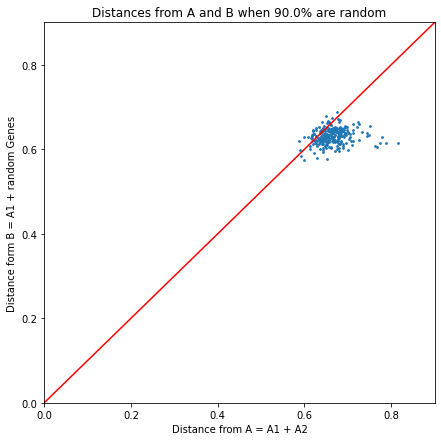

0.9279999999999999


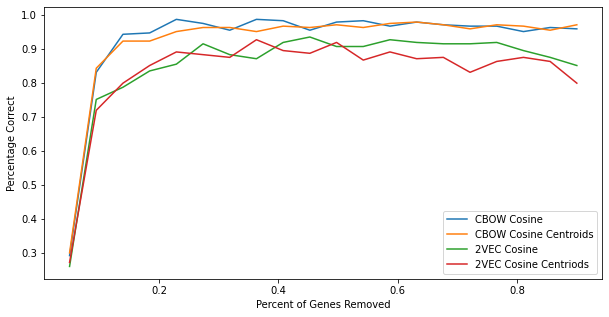

In [25]:
[cbow3Correct,cbow3MaxVal,percentsToRemove,Adist,Bdist] = getExperiment1Results(3,DB['CBOW']['model'],False,True)
[cbow1Correct,cbow1MaxVal,percentsToRemove1,_,_] = getExperiment1Results(4,DB['CBOW']['model'],False,True)

[vec3Correct,vec3MaxVal,percentsToRemove,Adist,Bdist] = getExperiment1Results(3,DB['2VEC']['model'],False,True)
[vec1Correct,vec1MaxVal,percentsToRemove1,_,_] = getExperiment1Results(4,DB['2VEC']['model'],False,True)

plt.figure(figsize=(7,7))
plt.scatter(Adist,Bdist,s=3)

plt.plot(range(0,1+int(np.ceil(cbow3MaxVal))),range(0,1+int(np.ceil(cbow3MaxVal))),c='r')

plt.title('Distances from A and B when {percent}% are random'.format(percent=100*percentsToRemove[-1]))
plt.axis([0,cbow3MaxVal,0,cbow3MaxVal])
plt.xlabel('Distance from A = A1 + A2')
plt.ylabel('Distance form B = A1 + random Genes')
plt.show()
print(np.average(cbow3Correct))

plt.figure(figsize=(10,5))
plt.plot(percentsToRemove,cbow3Correct,label='CBOW Cosine')
plt.plot(percentsToRemove,cbow1Correct,label='CBOW Cosine Centroids')
plt.plot(percentsToRemove,vec3Correct,label='2VEC Cosine')
plt.plot(percentsToRemove,vec1Correct,label='2VEC Cosine Centriods')
plt.legend()
plt.xlabel('Percent of Genes Removed')
plt.ylabel('Percentage Correct')
plt.show()

100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


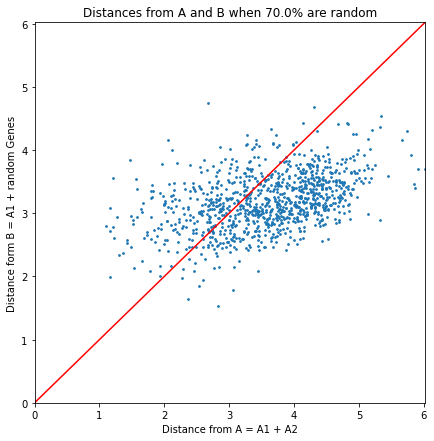

0.702


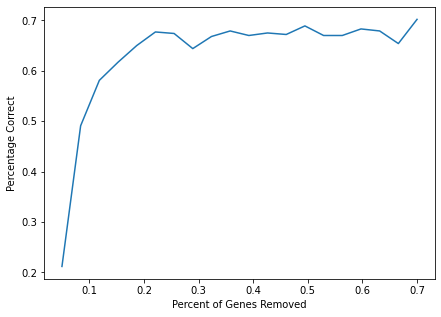

In [153]:
percentCorrect = []
percentsToRemove = np.linspace(0.05,0.7,20)
# percentsToRemove = np.linspace(0.5,0.9,1)


for percGenesToRemove in tqdm.tqdm(percentsToRemove):
    expData = [ runExperiement1(1,percGenesToRemove,saveToCsv,DB['CBOW']['model'],commonSets) for i in range(1000)]
    # print(expData)

    Adist = [x[0] for x in expData]
    Bdist = [x[1] for x in expData]

    As = [Adist[ind] > Bdist[ind] for ind in range(len(Adist))]

    percentCorrect.append(sum(As)/len(As))

maxVal = max(Adist+Bdist)
plt.figure(figsize=(7,7))
plt.scatter(Adist,Bdist,s=3)

plt.plot(range(0,1+int(np.ceil(maxVal))),range(0,1+int(np.ceil(maxVal))),c='r')

plt.title('Distances from A and B when {percent}% are random'.format(percent=100*percentsToRemove[-1]))
plt.axis([0,maxVal,0,maxVal])
plt.xlabel('Distance from A = A1 + A2')
plt.ylabel('Distance form B = A1 + random Genes')
plt.show()
print(sum(As)/len(As))

plt.figure(figsize=(7,5))
plt.plot(percentsToRemove,percentCorrect)
plt.xlabel('Percent of Genes Removed')
plt.ylabel('Percentage Correct')
plt.show()

In [ ]:
tempPd.to_csv('testingEntrezData.csv')

## Running GoSemSim on data

In [34]:
groundsMF = np.genfromtxt('grounds_experiment1.csv')
randsMF = np.genfromtxt('rands_experiment1.csv')

groundsBP = np.genfromtxt('grounds_experiment1BP.csv')
randsBP = np.genfromtxt('rands_experiment1BP.csv')

groundsCC = np.genfromtxt('grounds_experiment1CC.csv')
randsCC = np.genfromtxt('rands_experiment1CC.csv')

def parseGoSemData(grounds,rands):
    percentCorrectGo = []
    percentsToRemoveGo = np.linspace(0.05,0.9,20)
    # percentsToRemove = np.linspace(0.5,0.9,1)
    ind = 0

    for percGenesToRemove in tqdm.tqdm(percentsToRemoveGo):
    #     expData = [ runExperiement1(2,percGenesToRemove,True) for i in range(1000)]
        # print(expData)

        Adist = grounds[ind*1000:(ind+1)*1000]
        Bdist = rands[ind*1000:(ind+1)*1000]

        As = [Adist[ind] > Bdist[ind] for ind in range(len(Adist))]

        percentCorrectGo.append(sum(As)/len(As))
        ind+=1

    maxVal = max(Adist+Bdist)
    
    return [percentCorrectGo,percentsToRemoveGo,Adist,Bdist,As]

100%|██████████| 20/20 [00:00<00:00, 324.65it/s]


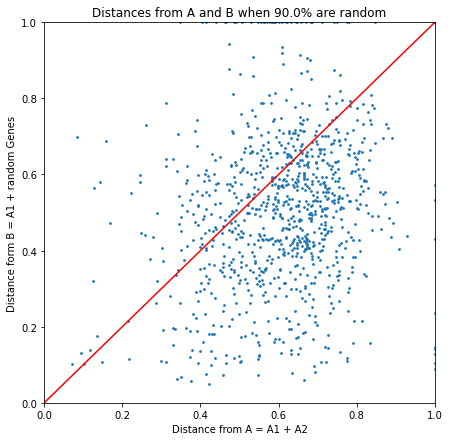

0.671


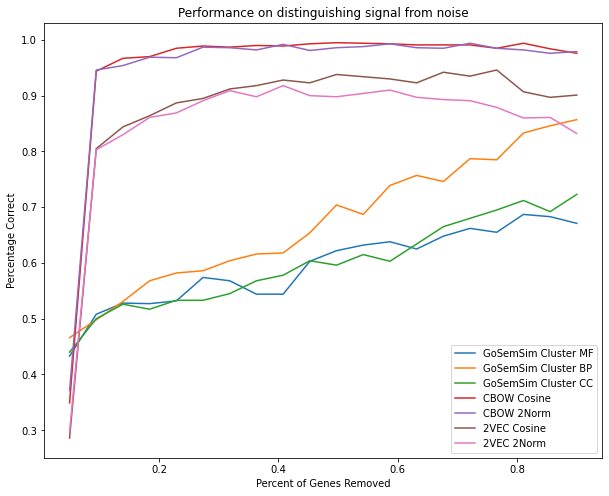

In [36]:

[percentCorrectGo,percentsToRemoveGo,Adist,Bdist,As] = parseGoSemData(groundsMF,randsMF)

[percentCorrectGoBP,percentsToRemoveGoBP,AdistBP,BdistBP,AsBP] = parseGoSemData(groundsBP,randsBP)

[percentCorrectGoCC,percentsToRemoveGoCC,AdistCC,BdistCC,AsCC] = parseGoSemData(groundsCC,randsCC)


plt.figure(figsize=(7,7))
plt.scatter(Adist,Bdist,s=3)

plt.plot(range(0,1+int(np.ceil(1))),range(0,1+int(np.ceil(1))),c='r')

plt.title('Distances from A and B when {percent}% are random'.format(percent=100*percentsToRemoveGo[-1]))
plt.axis([0,1,0,1])
plt.xlabel('Distance from A = A1 + A2')
plt.ylabel('Distance form B = A1 + random Genes')
plt.show()
print(sum(As)/len(As))

plt.figure(figsize=(10,8))
plt.plot(percentsToRemoveGo,percentCorrectGo,label='GoSemSim Cluster MF')
plt.plot(percentsToRemoveGoBP,percentCorrectGoBP,label='GoSemSim Cluster BP')
plt.plot(percentsToRemoveGoCC,percentCorrectGoCC,label='GoSemSim Cluster CC')


plt.plot(percentsToRemove,cbow3Correct,label='CBOW Cosine')
plt.plot(percentsToRemove,cbow1Correct,label='CBOW 2Norm')
plt.plot(percentsToRemove,vec3Correct,label='2VEC Cosine')
plt.plot(percentsToRemove,vec1Correct,label='2VEC 2Norm')
# plt.plot(percentsToRemove,percentCorrect,label='Heuristic GeneSet Distance')
plt.legend()
plt.title('Performance on distinguishing signal from noise')
plt.xlabel('Percent of Genes Removed')
plt.ylabel('Percentage Correct')
plt.show()


In [ ]:
import random
newDB = []

lenA1 = float(len(A1))
lenA2 = float(len(A2))

for i in range(100):
    randPercA1 = random.random()
    randPercA2 = 1 - randPercA1
    randlen1 = int(np.floor(randPercA1*lenA1))
    randlen2 = int(np.floor(randPercA2*lenA2))
    
    A1sample = random.sample(A1, randlen1)
    A2sample = random.sample(A2, randlen2)
    
    newDB.append((A1sample + A2sample,randlen1))

In [ ]:
distsRandExp = [ [getGeneSetDistance(A1,sample[0],geneEmbDistance),getGeneSetDistance(A2,sample[0],
                                                                                    geneEmbDistance),sample[1]] for sample in newDB]

In [ ]:
distanceFromA1 = [x[0] for x in distsRandExp]
distanceFromA2 = [x[1] for x in distsRandExp]
percFromA1 = [x[2] for x in distsRandExp]

plt.scatter(percFromA1,distanceFromA1,s=2)
plt.show()

plt.scatter(distanceFromA1,distanceFromA2,s=2)
plt.show()


In [60]:
mapping = pd.read_csv('hsapiens_genesymbol_entrezgene.table.txt',sep='\t',header=None)

lol = mapping.values.tolist()
mappingDict = dict()
mappingDictInv = dict()
for item in lol:
    mappingDictInv[item[0]] = item[1]

    mappingDict[item[1]] = item[0]
    
mapping.head()

,0,1
0,1,A1BG
1,2,A2M
2,3,A2MP1
3,9,NAT1
4,10,NAT2


# Experiment 2: Consistency with GO semantic similarity

In [23]:
iouData = []

for ind in tqdm.tqdm(range(len(commonSets))):
    tempData = []
    geneSet1 = set(commonSets[ind])
    
    for ind2 in range(len(commonSets)):
        geneSet2 = set(commonSets[ind2])
        if ind < ind2: 
            iou = IOU(geneSet1,geneSet2)
            if iou > 0.05 and iou < 1:
                tempData.append((iou,len(geneSet1.intersection(geneSet2)),len(geneSet2),geneSet1,geneSet2))
    iouData.append(tempData)
print(len(iouData))
print(len(iouData)/(len(commonSets)*len(commonSets)))


100%|██████████| 2131/2131 [00:10<00:00, 206.95it/s]

2131
0.0004692632566870014


In [24]:
counter = 0
filteredData = []
for data in iouData:
    for ind in range(len(data)):
        data1 = data[ind]
        for ind2 in range(len(data)):
            if ind != ind2:
                data2 = data[ind2]
                if data1[1] == data2[1] and data1[2] == data2[2]:
                    counter += 1
                    filteredData.append([data1,data2])

                
print(counter)

4606


In [26]:
print(filteredData[0])

[(0.10714285714285714, 3, 16, {'IL1B', 'CXCL6', 'TNFAIP2', 'ICAM1', 'NFKB1', 'CXCL3', 'PTX3', 'NFKBIA', 'CD83', 'IL6', 'CXCL2', 'OLR1', 'CXCL8', 'IRF1', 'RELA'}, {'CREBBP', 'HDAC3', 'IKBKG', 'IKBKB', 'TNF', 'RIPK1', 'NFKB1', 'FADD', 'RELA', 'EP300', 'TRAF6', 'TNFRSF1A', 'NFKBIA', 'CHUK', 'TNFRSF1B', 'TRADD'}), (0.10714285714285714, 3, 16, {'IL1B', 'CXCL6', 'TNFAIP2', 'ICAM1', 'NFKB1', 'CXCL3', 'PTX3', 'NFKBIA', 'CD83', 'IL6', 'CXCL2', 'OLR1', 'CXCL8', 'IRF1', 'RELA'}, {'MYC', 'HRAS', 'TNF', 'NFKB1', 'JUN', 'RELA', 'MAPK3', 'RAF1', 'MAPK1', 'PRKCA', 'PLCB1', 'PRKCB', 'NFKBIA', 'CUZD1', 'FOS', 'MAP2K1'})]


In [27]:
def getGeneSetPairs(geneSetDataPair):
    data1 = geneSetDataPair[0]
    data2 = geneSetDataPair[1]
    
    groundGeneSet = data1[3]
    
    comparisonGeneset1 = data1[4]
    comparisonGeneset2 = data1[4]
    
    return ((groundGeneSet,comparisonGeneset1,comparisonGeneset2))

In [33]:
counter = 0

pairs = [getGeneSetPairs(genesetpair) for genesetpair in filteredData]

for triplet in pairs:
    if triplet[1] != triplet[2]:  
        counter +=1
print(counter)
distancePairs = [[geneSetDistance(genesetpair[0],genesetpair[1],4,DB['CBOW']['model']),geneSetDistance(genesetpair[0],genesetpair[2],4,DB['CBOW']['model'])] for genesetpair in pairs]

0


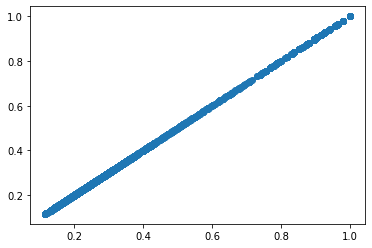

In [31]:
plt.scatter([x[0] for x in distancePairs],[x[1] for x in distancePairs])
plt.show()

In [37]:
testData = pd.read_csv('testingEntrezData.csv')

In [120]:
count = 0
def parseEntrezData(row):    
    A = parseStrGeneSet(row[1])
    A1 = parseStrGeneSet(row[2])
    B = parseStrGeneSet(row[3])
        
    return [A,A1,B]

def parseStrGeneSet(geneSetStr):
    geneSet = set()
    lst = geneSetStr.split(';')
    for geneStr in lst:
        if geneStr:
            geneEntrezNum = int(geneStr)
            geneSet.add(mappingDictInv[geneEntrezNum])
    return geneSet
    
ADists = []
BDists = []
ious = []
for row in testData.values.tolist():
    [A,A1,B] = parseEntrezData(row)
    iou = IOU(A,A1)
    ious.append(iou)
    ADist = getGeneSetDistance(A,A1,3,DB['2VEC']['model'])
    BDist = getGeneSetDistance(B,A1,3,DB['2VEC']['model'])

    ADists.append(ADist)
    BDists.append(BDist)
    
groundsBP = np.genfromtxt('grounds_experiment1BP.csv')
randsBP = np.genfromtxt('rands_experiment1BP.csv')

<ipython-input-8-f89ed3b55e7e>:27: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  tempVec = geneModel.wv[myGene]
<ipython-input-8-f89ed3b55e7e>:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  avgVec += geneModel.wv[gene]


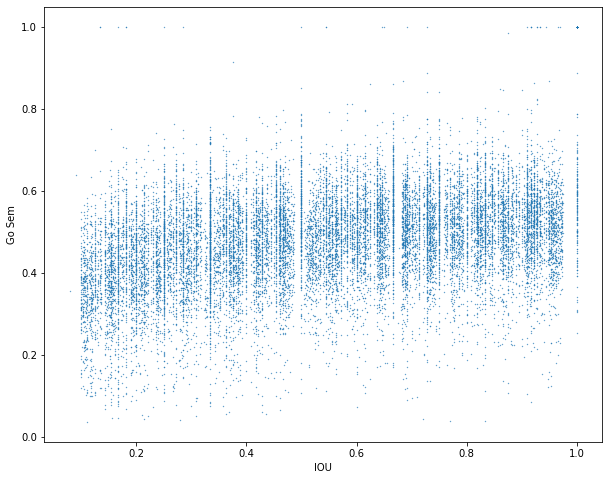

In [164]:
plt.figure(figsize=(10,8))
plt.scatter(ious[:],randsBP[1:],s=0.1)
plt.xlabel('IOU')
plt.ylabel('Go Sem')
plt.show()

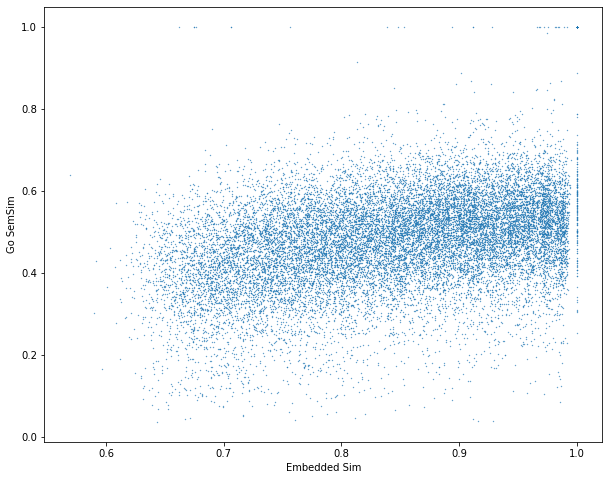

In [170]:
plt.figure(figsize=(10,8))
plt.scatter(ADists[:],randsBP[1:],s=0.1)
plt.xlabel('Embedded Sim')
plt.ylabel('Go SemSim')
plt.show()